In [1]:
from PIL import Image
import numpy as np
import os, sys
from pathlib import Path
root_path = Path.cwd().parents[1]
if str(root_path) not in sys.path:
  sys.path.append(str(root_path))
print(f"{root_path=}")

root_path=PosixPath('/home/yy/Coding/GitHub/KataCR')


In [14]:
from katacr.detection.parser import get_args_and_writer
from katacr.detection.model import get_state
from katacr.utils.model_weights import load_weights

# model_name = 'YOLOv5_v0.4.3_compact_box'
model_name = 'YOLOv5_v0.4.3_back'
# model_name = 'YOLOv5_v0.4.3'
args = get_args_and_writer(no_writer=True, input_args="--num-unit 30".split())
args.model_name = model_name
args.path_logs = root_path / "logs"
path_debug = args.path_logs / "debug"
args.path_cp = args.path_logs / (model_name + '-checkpoints')
args.load_id = 80
state_ok = load_weights(get_state(args), args)
# args.load_id = 70
# state_bad = load_weights(get_state(args, use_init=False), args)

Successfully load weights from '/home/yy/Coding/GitHub/KataCR/logs/YOLOv5_v0.4.3_back-checkpoints/YOLOv5_v0.4.3_back-0080'


In [15]:
%load_ext autoreload
%autoreload 2
# from katacr.detection.predict import Predictor
from katacr.detection.predict import Predictor
from katacr.utils.detection.data import show_box
predict_ok = Predictor(args, state_ok)
# predict_bad = Predictor(args, state_bad)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from katacr.detection.dataset_builder import DatasetBuilder
args.batch_size = 1
ds_builder = DatasetBuilder(args)
train_ds = ds_builder.get_dataset(subset='train')
val_ds = ds_builder.get_dataset(subset='val')
# iter_ds = iter(train_ds)
iter_ds = iter(val_ds)

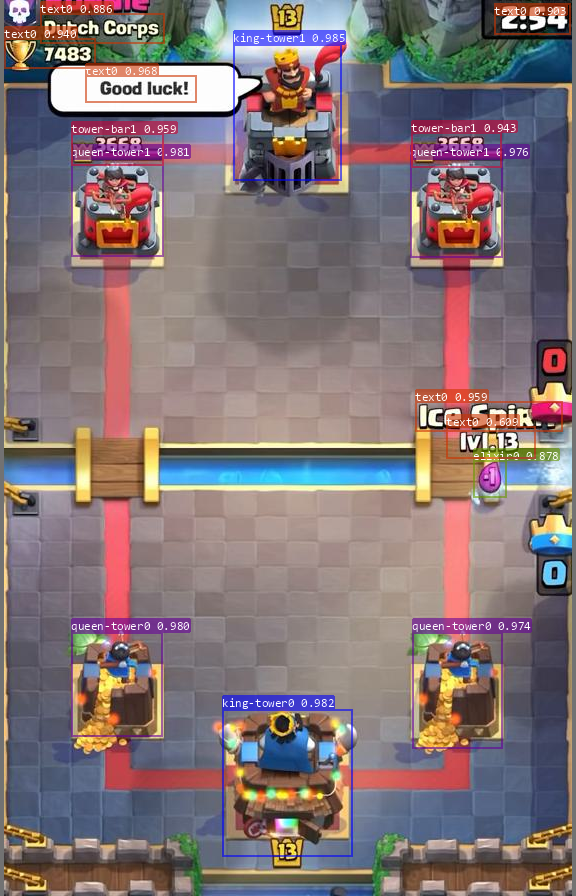


(eog:7910): EOG-WARNING **: 18:40:49.541: Couldn't load icon: Icon 'image-loading' not present in theme candy-icons


In [19]:
x, tbox, tnum = next(iter_ds)
x, tbox, tnum = x.numpy().astype(np.float32) / 255., tbox.numpy(), tnum.numpy()
pbox = predict_ok.update(x, nms_conf=0.4, nms_iou=0.65)
show_box(x[0], pbox[0], use_overlay=True, show_conf=True)
# pbox = predict_bad.update(x, nms_conf=0.5, nms_iou=0.65)
# show_box(x[0], pbox[0], use_overlay=True)

In [4]:
from tqdm import tqdm
# Test
from katacr.detection.dataset_builder import DatasetBuilder
args.batch_size = 32
args.repeat = 1
ds_builder = DatasetBuilder(args)
train_ds = ds_builder.get_dataset(subset='train')
val_ds = ds_builder.get_dataset(subset='val')

In [5]:
predict_ok.reset()
for x, tbox, tnum in tqdm(val_ds):
  x, tbox, tnum = x.numpy().astype(np.float32) / 255.0, tbox.numpy(), tnum.numpy()
  predict_ok.update(x, tbox, tnum)
print(predict_ok.p_r_ap50_ap75_map())

100%|██████████| 52/52 [00:45<00:00,  1.14it/s]

(0.6166687186328307, 0.7489227505774132, 0.719977428878618, 0.5924525518899455, 0.5139425253566987)


In [ ]:
# 12: 0.12977949105948913, 0.19215412920599756, 0.15634556500708421, 0.11553331942678603, 0.10764328207361266